In [1]:
import sqlalchemy as sq
import pymysql

import pandas as pd
import numpy as np

import os
import csv

import datetime as dt

sq.__version__

'1.0.12'

In [2]:

def convert_unixtime(stamp):
    return dt.datetime.fromtimestamp(
        int(stamp)
    ).strftime('%Y-%m-%d')

## Set up Dept List/Dict

In [3]:
dept_dict = {}

data_path = r'/Users/toferc/Documents/Data/'
output_path = r'/Users/toferc/Documents/Report Card/April/'

In [4]:
with open(os.path.join(data_path, 'csv_keys.csv'), "r") as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)
    
    for row in reader:
        email, acronym = row
        dept_dict[email] = acronym

dept_dict['cadets.gc.ca'] = 'CADETS'
dept_dict['canada.gc.ca'] = 'CANADA'
dept_dict['canada.ca'] = 'CANADA'
dept_dict['tribunal.gc.ca'] = 'TRIBUNAL'
dept_dict['cannor.gc.ca'] = 'CED/DEC'
dept_dict['ci-oic.gc.ca'] = 'CI/OIC'
dept_dict['ccgs-ngcc.gc.ca'] = 'CCGS/NGCC'
dept_dict['god.ccgs-ngcc.gc.ca'] = 'CCGS/NGCC'
dept_dict['clo-ocol.gc.ca'] = 'OCOL/CLO'
dept_dict['csps.gc.ca'] = 'CSPS/EFPC'
dept_dict['interenational.gc.ca'] = 'DFAITD/MAECD'
dept_dict['cnb-ncw.gc.ca'] = 'CNB/NCW'
dept_dict['ncw-cnb.gc.ca'] = 'CNB/NCW'
dept_dict['nfb.gc.ca'] = 'NFB/ONF'
dept_dict['nrccan-rncan.gc.ca'] = 'NRCAN/RNCAN'
dept_dict['nserc-crsng.gc.ca'] = 'NSERC/CRSNG'
dept_dict['pbc-clcc.gc.ca'] = 'PBC/CLCC'
dept_dict['pco.bcp.gc.ca'] = 'PCO/BCP'
dept_dict['pipsc.ca'] = 'PIPSC/IPFPC'
dept_dict['ps.sp.gc.ca'] = 'PS/SP'
dept_dict['servicecanada.gc.ca.gc.ca'] = 'HRSDC/RHDSC'
dept_dict['fintrac-canafe.gc.ca'] = 'FINTRAC'
dept_dict['gmail.com'] = 'GMAIL'
dept_dict['tribunbal.gc.ca'] = 'TRIBUNAL'

In [5]:
def find_dept(email):
    ampersand = email.find('@')
    tail = email[ampersand + 1:]
    try:
        return dept_dict[tail]
    except KeyError:
        return "OTHER"

In [6]:
dept_list = []

for k, v in dept_dict.items():
    dept_list.append(v)

dept_list = set(dept_list)

In [7]:
# Load CIOC members and FTE counts

cioc_depts = pd.read_csv(os.path.join(data_path, 'CIOC_depts_jan_2016.csv'),
                        thousands=',')

In [8]:
cioc_depts.describe()

,FTEs as of March 31st
count,33.000000
mean,5956.151515
std,7482.144496
min,577.000000
25%,918.000000
50%,4108.000000
75%,5935.000000
max,35862.000000


## Connect to DB

In [9]:
password = input('Enter Password: ')

Enter Password: gcped!a


In [29]:
# MariahDB = 165
# MYSQL = 117

db_connection = "mysql+pymysql://root:{}@192.168.2.117:3306/elgg112".format(
    password)

In [30]:
engine = sq.create_engine(db_connection,encoding='latin1', echo=False)

In [31]:
conn = engine.connect()

In [32]:
engine.connect()

In [33]:
from sqlalchemy.orm import sessionmaker, relationship
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import and_, or_
Session = sessionmaker(bind=engine)

In [34]:
Session.configure(bind=engine)
session = Session()

In [35]:
Base = automap_base()

Base.prepare(engine, reflect=True)

In [36]:
# Set up mappings

Users = Base.classes.elggusers_entity
Groups = Base.classes.elgggroups_entity
Relationships = Base.classes.elggentity_relationships
Entities = Base.classes.elggentities
Objects = Base.classes.elggobjects_entity
MetaData = Base.classes.elggmetadata
MetaStrings = Base.classes.elggmetastrings
Annotations = Base.classes.elggannotations


### Guide to Elgg Entities

Blogs = Entities(subtype=5)
Group_Members = Users(relationship=member)
Discussions = Entities(subtype=7)
Pages = Entities(subtype=10)
Wire = Entities(subtype=17)

Content = Entities(subtype) -> entity_guid
    Elggmetadata(entity_guid) -> name_id, value_id
    Elggmetastrings(name_id OR value_id)
    
#Comments
Blog is container entity - GUID = blog guid

Blog guid = 10
search container for blog guid, return container guid
elggmetadata(container_guid)
Elggmetastrings(name_id OR value_id)

#Skills
user_GUID -> elggmetadata(container_guid) - name_id = 60

In [18]:
# Set up subtype objects of interest

subtypes = {'blogs': 5,
            'discussions': 7,
            'pages': 10,
            'wires': 17,
            'files': 1,
            'images': 19,
            'bookmarks': 8,
            'ideas': 42
           }

subtype_list = "5 7 10 17 1 19 8 42".split()

## Pull Blogs

In [19]:
# Test for pulling out blog info
# Cut out: entity.guid, entity.subtype, user.name, objects.title, 

blogs = []

for entity, objects in session.query(
    Entities, Objects).filter(
        Entities.subtype == 5,
        Objects.guid == Entities.guid):
    blogs.append((objects.guid, objects.title, objects.description))

In [20]:
tags = []

for entity, data, strings in session.query(
    Entities, MetaData, MetaStrings).filter(
        Entities.subtype == 5,
        Entities.guid == MetaData.entity_guid).filter(
        or_ (MetaStrings.id == MetaData.value_id,
        MetaStrings.id == MetaData.name_id)):
    tags.append((entity.guid, data.name_id, data.value_id, strings.id,
                 strings.string))

In [21]:
tags[:2]

[(30, 119, 120, 119, 'tags'), (30, 119, 120, 120, 'new')]

In [22]:
# Scripts for sorting tags and linking them to guids

from collections import defaultdict

tag_dict = defaultdict(list)

for data in tags:
    guid, name_id, value_id, string_id, string = data
    if name_id == string_id and string == 'tags':
        tag_dict.setdefault(guid, []).append(value_id)
        
strings = {}
        
for data in tags:
    guid, name_id, value_id, string_id, string = data
    strings[string_id] =  string
    

def replace_string_id(tag_list):
    return [strings.get(t).lower() for t in tag_list]

final_tags = defaultdict(list)

for k, v in tag_dict.items():
    final_tags[k] = replace_string_id(v)


In [23]:
len(tag_dict)

3897

In [24]:
strings = {}
        
for data in tags:
    guid, name_id, value_id, string_id, string = data
    strings[string_id] =  string


In [25]:
len(strings)

8730

In [26]:
tag_dict[1499271]

[21156, 99059, 123733, 137407]

In [27]:

def replace_string_id(tag_list):
    return [strings.get(t).lower() for t in tag_list]

'''for element in tag_dict[1499271]:
    print(element)
    tag_dict[element] = strings.get(tag)'''

'for element in tag_dict[1499271]:\n    print(element)\n    tag_dict[element] = strings.get(tag)'

In [28]:
replace_string_id(tag_dict[1499271])

['scc', 'csc', 'gc2020', 'bp2020']

In [29]:
final_tags = defaultdict(list)

for k, v in tag_dict.items():
    final_tags[k] = replace_string_id(v)

In [30]:
final_tags

defaultdict(list,
            {8085509: ['aandc',
              'bc region',
              'aandc bc region',
              'expression of interest'],
             12877839: ['productivity',
              'goals',
              'tips',
              'time management',
              'conseils',
              'buts',
              'productivité',
              'gestion du temps'],
             15458323: ['meeting',
              'facilitator',
              'summerside',
              'christmas',
              'stc'],
             2648750: ['aboriginal autochtone activités'],
             5554198: ['innovation',
              'lean',
              'peak',
              'denver',
              'savings',
              'municipal',
              'city'],
             1651426: ['gcconnex',
              'clicks and tips',
              'technologie cool',
              'clicks &amp; tips'],
             131100: ['cs',
              'sharepoint',
              'powershell',
              '.

In [31]:
len(final_tags)

3897

In [33]:
# Count the frequency of each tag from our text

tag_frequency = defaultdict(int)

for item in final_tags:
    for tag in final_tags[item]:
        tag_frequency[tag] += 1

In [34]:
tag_frequency

defaultdict(int,
            {'': 5,
             'replication': 1,
             'mentorship': 2,
             'failure reports; playbooks; lessons learned; project charter; innovation; collaboration; knowledge exchange; knowledge transfer; lab; hub; sharing; convening;': 1,
             'thou': 1,
             'webinar': 7,
             'bike tour': 1,
             'igas': 1,
             'case study': 1,
             'hpfb': 1,
             'seekers': 1,
             'slo-pitch': 2,
             'crowdfunded': 1,
             'rehabilitation': 1,
             'roku': 1,
             'agility in project management practices': 1,
             'young professionals': 3,
             'quantity': 1,
             'résilience': 1,
             'participation': 11,
             'appreciation': 12,
             'whitehorse': 1,
             'iscm': 4,
             'new': 5,
             'conversations': 2,
             'lessons learned': 10,
             'eu': 2,
             'scoial media tip

In [35]:
tag_freq = pd.DataFrame.from_dict(tag_frequency, orient='index')

In [36]:
tag_freq.columns = ['frequency']
tag_freq.head()

,frequency
,5
replication,1
first thoughts,1
mentorship,2
kale,1


In [37]:
tag_freq.sort_values(by='frequency', inplace=True, ascending=False)

In [19]:
tag_freq.head()

NameError: name 'tag_freq' is not defined

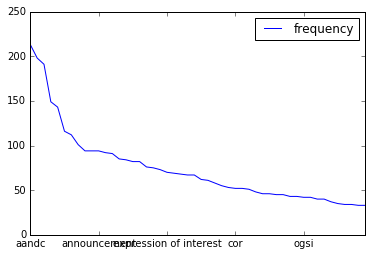

In [39]:
%matplotlib inline

tag_freq.head(50).plot()

In [40]:
tag_freq.to_csv('blog_tags.csv')

In [41]:
from collections import OrderedDict

In [42]:
# Create a sorted dictionary based on the frequency

sorted_tag_freq = OrderedDict(sorted(tag_frequency.items(),
                                key=lambda kv: kv[1],
                                reverse=True))

In [43]:
sorted_tag_freq

OrderedDict([('aandc', 213),
             ('aandc bc region', 198),
             ('bc region', 191),
             ('leadership', 149),
             ('engagement', 143),
             ('gcconnex', 116),
             ('clicks and tips', 112),
             ('learning', 101),
             ('cfia', 94),
             ('announcement', 94),
             ('nmc', 94),
             ('innovation', 92),
             ('open source', 91),
             ('blueprint 2020', 85),
             ('social media', 84),
             ('acia', 82),
             ('collaboration', 82),
             ('manager', 76),
             ('gcwcc', 75),
             ('communications', 73),
             ('expression of interest', 70),
             ('management', 69),
             ('cool tech tip', 68),
             ('consultation', 67),
             ('community', 67),
             ('bp2020', 62),
             ('web 2.0', 61),
             ('project management', 58),
             ('objectif 2020', 55),
             ('clicks', 53

In [44]:
blogs[7]

(344,
 'CBSA Second Life Pilot Project',
 "I am currently leading a pilot project to trial Second Life as a training tool to support recruit training at Canada Border Services Agency.  I've partnered with some colleagues at Loyalist College to use a virtual border created by Loyalist to support CBSA training.  Loyalist College has been using their virtual border for almost 2 years to support learners in the Customs Law Enforcement Diploma Program.  They've used it with over 50 students and have reported tremendous success.  After meeting Ken Hudson from Loyalist at a conference last year, we agreed to a pilot project to see if the tool would work in CBSA.  We will be trying the virtual border in SL with 250 of our recruits over the coming two months.  We hope to see if the technology is accessible, what technical issues present themselves, and importantly, to see what effect it has on our learners in terms of performance and learning.  \r\n\r\nI'll be presenting our preliminary finding

In [45]:
blogs[11]

(449,
 'Details',
 "So now that I'm connected to a couple of people via this tool - I'm going to start giving my opinion on the little things that work - and that don't. When logging in to my page I can see that somebody I'm connected to updated their status. But that's not what I want to know. I want to know what that update is. If we look at the way facebook and twitter work - you just get the update, not information that the update has been changed. That's a click away. And when we start connecting to our larger networks, that's going to mean a waste of time. I'd like a snapshot of updates right off the bat. So my question is, can we modify that in this tool?\r\n\r\nPatrycja")

## Groups

In [22]:
# Pull groups from DB

groups = []

for group, entity in session.query(
    Groups, Entities).filter(
        Entities.guid == Groups.guid):
    groups.append((group.guid, group.name, group.description,
                  entity.owner_guid, convert_unixtime(entity.time_created)))

In [23]:
groups[:20]

[(122,
  'Innovation Group',
  'For discussing various innovative ideas with a goal of improving the effectiveness of our working environment.',
  106,
  '2008-12-19'),
 (275,
  'Community Targets',
  '<p>A place to gather information on communities that we will be inviting to pilot GEDS+ and share how we will evaluate and capture lessons learned.</p>\r\n<p>Suggested communication emails can also be found on this page (left hand sidebar) to faciliate and standardize communication with communities.\xa0</p>',
  151,
  '2009-01-13'),
 (291,
  'CTO/Innovation - Telepresence PoC',
  'Telepresence is a set of technologies that allow a person to seem like they are present in another location.\r\n\r\nBased on the deployment of meeting rooms equipped with VoIP phones, CD-quality audio, high-definition video, specialized lighting, and high resolution plasma monitors that stream natural size images of the people attending the meeting.\r\n\r\nTelepresence is more than Video-Conferencing and Web-Co

In [38]:
# Pull tags from DB

group_tags = []

for group, entity, data, strings in session.query(
    Groups, Entities, MetaData, MetaStrings).filter(
        Groups.guid == Entities.guid,
        Entities.guid == MetaData.entity_guid).filter(
        or_ (MetaStrings.id == MetaData.value_id,
        MetaStrings.id == MetaData.name_id)):
    group_tags.append((entity.guid, data.name_id, data.value_id, strings.id,
                 strings.string))

In [48]:
group_tags

[(122, 57, 26, 26, ''),
 (122, 57, 26, 57, 'briefdescription'),
 (122, 59, 26, 26, ''),
 (122, 59, 26, 59, 'interests'),
 (122, 69, 26, 26, ''),
 (122, 69, 26, 69, 'website'),
 (122, 73, 14, 14, '0'),
 (122, 73, 14, 73, 'icontime'),
 (122, 132, 50, 50, '2'),
 (122, 132, 50, 132, 'membership'),
 (122, 133, 53, 53, '8'),
 (122, 133, 53, 133, 'group_acl'),
 (122, 1084679, 1084680, 1084679, 'content_access_mode'),
 (122, 1084679, 1084680, 1084680, 'unrestricted'),
 (275, 57, 337, 57, 'briefdescription'),
 (275,
  57,
  337,
  337,
  'Communities to be invited to pilot GEDS+, evaluation, lessons learned'),
 (275, 69, 26, 26, ''),
 (275, 69, 26, 69, 'website'),
 (275, 73, 96361, 73, 'icontime'),
 (275, 73, 96361, 96361, '1350781196'),
 (275, 132, 50, 50, '2'),
 (275, 132, 50, 132, 'membership'),
 (275, 133, 331, 133, 'group_acl'),
 (275, 133, 331, 331, '12'),
 (275, 1323, 72, 72, 'yes'),
 (275, 1323, 72, 1323, 'files_enable'),
 (275, 1324, 72, 72, 'yes'),
 (275, 1324, 72, 1324, 'forum_enable

In [42]:
# Scripts for sorting tags and linking them to guids

from collections import defaultdict


In [49]:
tag_dict = defaultdict(list)

for data in group_tags:
    guid, name_id, value_id, string_id, string = data
    if name_id == string_id and string == 'interests':
        tag_dict.setdefault(guid, []).append(value_id)

In [50]:
strings = {}
        
for data in group_tags:
    guid, name_id, value_id, string_id, string = data
    strings[string_id] =  string

In [51]:
def replace_string_id(tag_list):
    return [strings.get(t).lower() for t in tag_list]


In [52]:
final_tags = defaultdict(list)

for k, v in tag_dict.items():
    final_tags[k] = replace_string_id(v)


In [53]:
final_tags

defaultdict(list,
            {12017666: ['pwgsc', 'business planning', 'pwgsc pacific'],
             5857283: ['functional communities',
              'collectivités fonctionnelle'],
             11362315: ['my gchr', 'cab', 'change managment'],
             2850832: ['management', 'land', 'aandc'],
             4145173: ['vancouver',
              'british columbia',
              'co-op',
              'aandc',
              'bc region'],
             131098: ['cfqti'],
             5234715: ['data centre', 'data center', 'consolidation'],
             10575900: ['pses 2014',
              'saff 2014',
              'employee forum',
              'forum des employés'],
             5980190: ['communications',
              'management',
              'shared services canada'],
             12714018: ['innovation',
              'design thinking',
              'resiliency',
              'surge capacity',
              'user-centered design'],
             6955046: ['cic'],
      

In [54]:
# Associate groups and tags

class GCconnexGroup(object):
    
    def __init__(self, name, description, owner, created, tags):
        self.name = name
        self.description = description
        self.owner = owner
        self.created = created
        self.tags = tags
    
    def info(self):
        print('''
        Name: {name}
        Description: {}
        Owner: {}
        Date Created: {}
        Tags: {}'''.format(self.name, self.description, self.owner,
                          self.created, self.tags))


In [64]:
from bs4 import BeautifulSoup

In [67]:
group_info = []

for group in groups:
    guid, name, description, owner_guid, created = group
    name = BeautifulSoup(name, "lxml")
    description = BeautifulSoup(description, "lxml")
    tags = final_tags.get(guid, "None")
    group_info.append([name.text, description.text, owner_guid, created, tags])

In [69]:
len(group_info)

6446

In [70]:
group_df = pd.DataFrame(group_info)

In [73]:
group_df.head()

,0,1,2,3,4
0,Innovation Group,For discussing various innovative ideas with a...,106,2008-12-19,[]
1,Community Targets,A place to gather information on communities t...,151,2009-01-13,None
2,CTO/Innovation - Telepresence PoC,Telepresence is a set of technologies that all...,195,2009-01-14,[]
3,Communications,Looking at GEDS PLUS from a communications per...,391,2009-01-20,"[communications, web 2.0]"
4,Distance Learning Network (DLN) / Réseau d'app...,The DLN is a community of interest and experti...,257227,2009-02-11,"[web 2.0, collaboration, learning technologies..."


### Latent Dirichlet Allocation (LDA)

In [1]:
import logging
import gensim
import bz2
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
from gensim.utils import simple_preprocess, lemmatize
from gensim.parsing.preprocessing import STOPWORDS as STOPWORDS

from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize

tokenizer = RegexpTokenizer(r'\w+')

In [307]:
# Other method for stopwords - not using here.

from nltk.corpus import stopwords
import nltk

# create English stop word list
en_stops = set(stopwords.words('english'))
fr_stops = set(stopwords.words('french'))

public_service_stops = '''public service canada work http 
https travail gcconnex url'''.split()

In [308]:
public_service_stops

['public',
 'service',
 'canada',
 'work',
 'http',
 'https',
 'travail',
 'gcconnex',
 'url']

In [309]:
def tokenize(text):
    return [token for token in gensim.utils.simple_preprocess(text)
            if token not in STOPWORDS if token not in fr_stops
           if token not in public_service_stops if len(token) > 3]

In [294]:
print(tokenize(blogs[1][2]))

['thanks', 'diligent', 'work', 'colleagues', 'pwgsc', 'plan', 'starting', 'come', 'ready', 'users', 'elgg', 'joomla', 'sites', 'following', 'provisos', 'changes', 'profile', 'information', 'elgg', 'lost', 'complete', 'write', 'integration', 'profile', 'fields', 'directory', 'including', 'photo', 'lucky', 'directory', 'integration', 'complete', 'joomla', 'profile', 'info', 'sync', 'elgg', 'effort', 'profile', 'info', 'come', 'directory', 'significant', 'afford', 'time', 'joomla', 'extremely', 'contender']


In [295]:
#meaningful_words = [w for w in tokens if not w in en_stop if not w in fr_stop]

In [296]:
#print(meaningful_words)

In [38]:
from nltk.stem.porter import PorterStemmer

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [39]:
# Didn't end up going with this.

texts = [p_stemmer.stem(i) for i in meaningful_words]
print(texts)

['Thank', 'dilig', 'work', 'colleagu', 'PWGSC', 'plan', 'start', 'come', 'togeth', 'We', 'readi', 'let', 'user', 'log', 'ELGG', 'Joomla', 'site', 'follow', 'proviso', '1', 'Chang', 'made', 'profil', 'inform', 'ELGG', 'lost', 'complet', 'write', 'integr', 'profil', 'field', 'directori', 'includ', 'photo', 'lucki', '2', 'Onc', 'directori', 'integr', 'complet', 'Joomla', 'profil', 'info', 'NOT', 'sync', 'ELGG', 'The', 'effort', 'make', 'profil', 'info', 'come', 'app', 'directori', 'signific', 'afford', 'time', 'unless', 'Joomla', 'becom', 'extrem', 'seriou', 'contend']


In [310]:
# Set up loop to do this for all blogs
from bs4 import BeautifulSoup

texts = []

def blog_to_words(raw_blog):
    clean_blog = BeautifulSoup(raw_blog[2], "lxml")
    #prep_blog = clean_blog.get_text().lower()
    #tokens = tokenizer.tokenize(prep_blog)
    #meaningful_words = [w for w in tokens if not w in en_stops 
                        #if not w in fr_stops]
    #text = [p_stemmer.stem(i) for i in meaningful_words]
    texts.append(tokenize(clean_blog.get_text()))

In [311]:
for i, raw_blog in enumerate(blogs):
    blog_to_words(raw_blog)
    if (i+1)%500 == 0:
        print("Converted {} of {} blogs.".format(i+1, len(blogs)))
    
print("Done!")

Converted 500 of 9423 blogs.
Converted 1000 of 9423 blogs.
Converted 1500 of 9423 blogs.
Converted 2000 of 9423 blogs.
Converted 2500 of 9423 blogs.
Converted 3000 of 9423 blogs.
Converted 3500 of 9423 blogs.
Converted 4000 of 9423 blogs.
Converted 4500 of 9423 blogs.
Converted 5000 of 9423 blogs.
Converted 5500 of 9423 blogs.
Converted 6000 of 9423 blogs.
Converted 6500 of 9423 blogs.
Converted 7000 of 9423 blogs.
Converted 7500 of 9423 blogs.
Converted 8000 of 9423 blogs.
Converted 8500 of 9423 blogs.
Converted 9000 of 9423 blogs.
Done!


In [312]:
# Went to bed here
texts[9422]

['fraser',
 'wonderful',
 'explaining',
 'values',
 'ethics',
 'agency',
 'presentation',
 'best',
 'agency',
 'think',
 'today',
 'daily',
 'decisions',
 'years',
 'attended',
 'course',
 'think',
 'essential',
 'staff',
 'learn',
 'expected',
 'provided',
 'clear',
 'roadmap',
 'navigate',
 'thought',
 'processes',
 'especially',
 'represent',
 'agency',
 'paid',
 'taxpayer',
 'payers',
 'understand',
 'want',
 'biggest',
 'bang',
 'bucks',
 'brought',
 'attention',
 'lately',
 'impression',
 'presentation',
 'staff',
 'staff',
 'felt',
 'asked',
 'monitor',
 'report',
 'colleagues',
 'supervisors',
 'closer',
 'look',
 'opinion',
 'hope',
 'agree',
 'difference',
 'whistleblower',
 'snitch',
 'whistleblower',
 'considers',
 'size',
 'impact',
 'wrong',
 'personal',
 'risk',
 'involved',
 'desired',
 'outcome',
 'generally',
 'common',
 'good',
 'snitch',
 'busy',
 'body',
 'involves',
 'people',
 'business',
 'gets',
 'half',
 'story',
 'reports',
 'issues',
 'superiors',
 'personal

In [313]:
from gensim import corpora, models

dictionary = corpora.Dictionary(texts) # could include prune_at=2000

In [314]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [317]:
dictionary.save('gcconnex_blogs_dictionary_data')

In [329]:
# Generate the LDA model for our blog corpus

ldamodel = models.ldamulticore.LdaMulticore(corpus, num_topics=30,
                                           id2word = dictionary,
                                            chunksize=1000,
                                            passes=1)


In [331]:
ldamodel.print_topics(num_topics=20, num_words=3)

[(1, '0.006*people + 0.005*team + 0.004*time'),
 (14, '0.005*plus + 0.004*managers + 0.004*government'),
 (22, '0.005*information + 0.004*know + 0.004*management'),
 (11, '0.004*management + 0.004*time + 0.004*like'),
 (16, '0.005*people + 0.005*social + 0.004*data'),
 (6, '0.005*information + 0.004*management + 0.003*time'),
 (23, '0.004*people + 0.004*time + 0.003*government'),
 (13, '0.004*time + 0.004*managers + 0.003*people'),
 (7, '0.003*people + 0.003*team + 0.003*information'),
 (17, '0.003*team + 0.003*employees + 0.003*time'),
 (28, '0.004*information + 0.004*plus + 0.004*innovation'),
 (21, '0.004*plus + 0.004*data + 0.004*open'),
 (3, '0.006*information + 0.004*managers + 0.003*plus'),
 (5, '0.003*services + 0.003*time + 0.003*plus'),
 (25, '0.005*information + 0.004*government + 0.003*project'),
 (24, '0.005*information + 0.004*plus + 0.004*like'),
 (0, '0.004*information + 0.003*like + 0.003*plus'),
 (15, '0.007*information + 0.004*time + 0.003*like'),
 (4, '0.004*like + 

In [ ]:
# Consider trying Kaggle.com word2vec tutorial

In [332]:
ldamodel.top_topics(corpus, num_words=8)

[([(0.0064113492215871204, 'people'),
   (0.0045674367878287703, 'team'),
   (0.0042275255178425798, 'time'),
   (0.0034796623124814454, 'employees'),
   (0.003415863745990606, 'know'),
   (0.0031897403498157904, 'like'),
   (0.0029739294117169146, 'information'),
   (0.0027239789459736017, 'management')],
  -20.009585152101124),
 ([(0.0057369977970577685, 'information'),
   (0.0036448797948264449, 'managers'),
   (0.0033050540077045674, 'plus'),
   (0.0032106181667724445, 'change'),
   (0.0027960887125366347, 'team'),
   (0.0026087090857594437, 'people'),
   (0.0024634000973436741, 'time'),
   (0.0023795326215618104, 'like')],
  -20.35637917826644),
 ([(0.0040327411868136525, 'like'),
   (0.0039321179165850116, 'time'),
   (0.0032607788558016897, 'people'),
   (0.0028854388410568081, 'need'),
   (0.0027499448471598326, 'management'),
   (0.0026546190548295359, 'know'),
   (0.0024897987232405348, 'help'),
   (0.0024494724620255435, 'team')],
  -21.615934979685019),
 ([(0.00372426437623

In [334]:
from pprint import pprint

In [335]:
from collections import defaultdict, OrderedDict

In [336]:
frequency = defaultdict(int)

In [337]:
# Remove words that occur less than 5 times and than have less than 3 letters

texts = [[token for token in text if frequency[token] > 5 if len(token) > 3]
         for text in texts]

In [338]:
# Count the frequency of each token from our text

for text in texts:
    for token in text:
        frequency[token] += 1

In [339]:
# Create a sorted dictionary based on the frequency

sorted_freq = OrderedDict(sorted(frequency.items(),
                                key=lambda kv: kv[1],
                                reverse=True))

In [341]:
sorted_freq

OrderedDict([('appuyées', 0),
             ('retarde', 0),
             ('evaluation', 0),
             ('fonctionnerait', 0),
             ('axeloshttps', 0),
             ('thewillowgroup', 0),
             ('fabulous', 0),
             ('infusing', 0),
             ('opposed', 0),
             ('menu', 0),
             ('groupanswers', 0),
             ('aimeront', 0),
             ('chrsc', 0),
             ('community', 0),
             ('expedited', 0),
             ('imajin', 0),
             ('invitante', 0),
             ('rescheduling', 0),
             ('aidées', 0),
             ('décret', 0),
             ('shuttle', 0),
             ('récent', 0),
             ('personnalisé', 0),
             ('neurologically', 0),
             ('retains', 0),
             ('premila', 0),
             ('mackinnon', 0),
             ('clue', 0),
             ('trigger', 0),
             ('jazz', 0),
             ('shankar', 0),
             ('support', 0),
             ('thérapeutiques', 

In [55]:
tfidf_model = models.tfidfmodel.TfidfModel(
    corpus)

In [83]:
with open('blogs.csv', 'w+', encoding='latin-1') as f:
    for blog in blogs:
        f.write(blog)


In [90]:
# Prep for NLTK analysis

full_text = "\n".join(blogs)


tokens = word_tokenize(full_text)
text = nltk.Text(tokens)
sens = nltk.sent_tokenize(raw)


Frequency Distribution:
[]


AttributeError: 'list' object has no attribute 'dispersion_plot'

In [93]:
freq_long(text)

Please set a minimum length for the for the words: 6
Please enter the minimum number of times the word should appear: 20

Frequently Occurring Long Words:
["'BookAntiqua", "'Bookman", "'Calibri", "'Cambria", "'Century", "'Futura", "'Georgia", "'Helvetica", "'Lucida", "'Tahoma", "'Trebuchet", "'Verdana", "'courier", "'sans-serif", "'trebuchet", '**********', '******************************************************************************************************', '******************************************************************************************************************', '*******************************************************************************************************************', '-0.25in', '-0.75in', '.0001pt', '//afc.gc.ca', '//afc.gc.ca/', '//afc.gc.ca/ABOUTCOUNCIL/Updates/tabid/2874/language/en-US/Default.aspx', '//afc.gc.ca/events/eventscalendar.aspx', '//cfs-poib.nrcan.gc.ca/cafe-jen/Lists/Posts/Post.aspx', '//clicks.aweber.com/y/ct/', '//elgg.srv.gc.ca/elgg17/actio

In [ ]:
pos_trigrams(text)

showing info http://www.nltk.org/nltk_data/


True